# Bike Sharing Demand

### Overview
The goal of the project is to forecast the demand of the bikes used by a bike sharing system.

Bike sharing systems are services in which individuals can use bikes on a short term basis for a price. The bikes can be rented and returned in two different locations. Currently there are numerous applications offering such services. These applications record the usage data such as duration of travel, departure location, arrival location, and time elapsed. 
In this project, we will use a dataset that combines historical bike usage data with weather and forecast bike rental demand for the future. 

#### Methodology
We analyze three models: __Linear Regression__, __Suport Vector Regressor__ and __Random Forest Regressor__. We compare the cross validation scores of the three models and find the best model, as well as its optimal hyperparameters for our dataset.

### Data
We have hourly rental data over two years. The _first 19 days of each month_ are used as _training set_ (~11k rows), while the _remaining days_ of the month are the _test set_ (~6.5k rows). The goal is to predict the __total count of bikes__ rented during each hour covered by the test set. 

The dataset is downloaded from https://www.kaggle.com/c/bike-sharing-demand/data. 

It has the following fields:

__datetime__ - hourly date + timestamp  
__season__ -  1 = spring, 2 = summer, 3 = fall, 4 = winter  
__holiday__ - whether the day is considered a holiday  
__workingday__ - whether the day is neither a weekend nor holiday  
__weather__ -    1: Clear, Few clouds, Partly cloudy, Partly cloudy  
    2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  
    3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds  
    4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog  
__temp__ - temperature in Celsius  
__atemp__ - "feels like" temperature in Celsius  
__humidity__ - relative humidity  
__windspeed__ - wind speed  
__casual__ - number of non-registered user rentals initiated  
__registered__ - number of registered user rentals initiated  
__count__ - number of total rentals  

#### Setup

In [1]:
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_log_error

import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import scatter_matrix
import seaborn as seabornInstance

np.random.seed(0)


In [6]:
bikes_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

print("Train dataset has {} samples and {} attributes".format(*bikes_df.shape))
print("Test dataset has {} samples and {} attributes".format(*test_df.shape))

Train dataset has 10886 samples and 12 attributes
Test dataset has 6493 samples and 9 attributes


In [7]:
print(bikes_df.dtypes)
bikes_df.head()

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


We have 11 feature columns and the target __count__ which is an integer. _Season, holiday, workingday, weather_ are __categorical__ features while _temp, humidity, windspeed, atemp, casual, registered_ are __continuous__ variables.

Test dataset has the same feature columns, except _casual_ and _registered_ columns.

In [53]:
test_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [124]:
bikes_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,weekday,hour,month_index
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,191.574132,2011.501929,6.521495,3.013963,11.541613,9.786331
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,181.144454,0.500019,3.444373,2.004585,6.915838,6.345098
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,1.000000,2011.000000,1.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,42.000000,2011.000000,4.000000,1.000000,6.000000,5.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,145.000000,2012.000000,7.000000,3.000000,12.000000,9.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,284.000000,2012.000000,10.000000,5.000000,18.000000,14.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,977.000000,2012.000000,12.000000,6.000000,23.000000,24.000000


### Data modifications

First, let's modify our data to become more usable.

We extract year, month, day of the week and hour from the datetime. Then we drop datetime since we don't need it anymore, and casual and registered columns to match the test data.

In [8]:
bikes_df['year'] = pd.DatetimeIndex(bikes_df.datetime).year
bikes_df['month'] = pd.DatetimeIndex(bikes_df.datetime).month
bikes_df['weekday'] = pd.DatetimeIndex(bikes_df.datetime).dayofweek
bikes_df['hour'] = pd.DatetimeIndex(bikes_df.datetime).hour

bikes_df = bikes_df.drop(['datetime', 'casual', 'registered'], axis = 1)

#### Time series

We are dealing with time series. In real-world scenario, obviously the model only has information to the data __prior to the rental period__. For this reason, for each month we will predict the total count of bikes rented, using only information available from previous months. 

Our dataset consists of two years. In order to simplify the calculations, we will use month_index that would be in range of 1-24 for the two years' months. We will not use this column for model training. 

After the modifications, the data set looks like this: 

In [9]:
bikes_df['month_index'] = (bikes_df['year'] - 2010) * bikes_df['month']
bikes_df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,weekday,hour,month_index
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,5,0,1
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,5,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,5,2,1
3,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,5,3,1
4,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,5,4,1


A few observations:
* Training dataset grows over time. Therefore, the model could __improve over time__.
* The problem lacks resemblance with real world scenario, since in real world over time we would not have __large gaps in "train" data__. Month 13 predictions would have full 12 months of actual data, not two thirds of each the data from the each month, etc.

### Data visualizations

Now, we try to plot a few features' correlation with the count and see if we can manually see any relationship between them. 

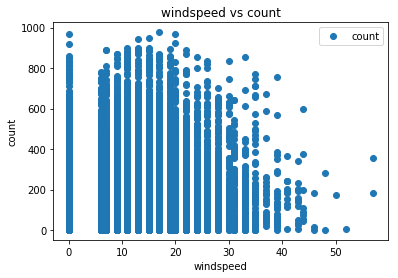

In [111]:
bikes_df.plot(x='windspeed', y='count', style='o')  
plt.title('windspeed vs count')  
plt.xlabel('windspeed')
plt.ylabel('count')
plt.show()

The gap on this graph shows that for some parts of the data the __windspeed value is missing__. This can be fixed by predicting those values using a method such as Random Forests.

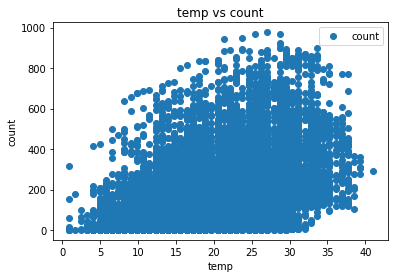

In [116]:
bikes_df.plot(x='temp', y='count', style='o')  
plt.title('temp vs count')  
plt.xlabel('temp')  
plt.ylabel('count')  
plt.show()

These figures also show that __count is skewed__ towards right. It is desirable to have Normal distribution as most of the machine learning techniques require dependent variable to be Normal. One possible solution is to take log transformation on "count" variable after removing outlier data points.

We can see average windspeed graph.

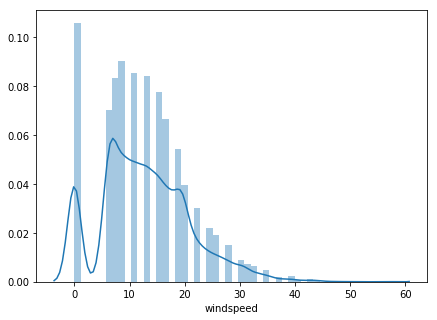

In [112]:
plt.figure(figsize=(7, 5))
plt.tight_layout()
seabornInstance.distplot(bikes_df['windspeed'])

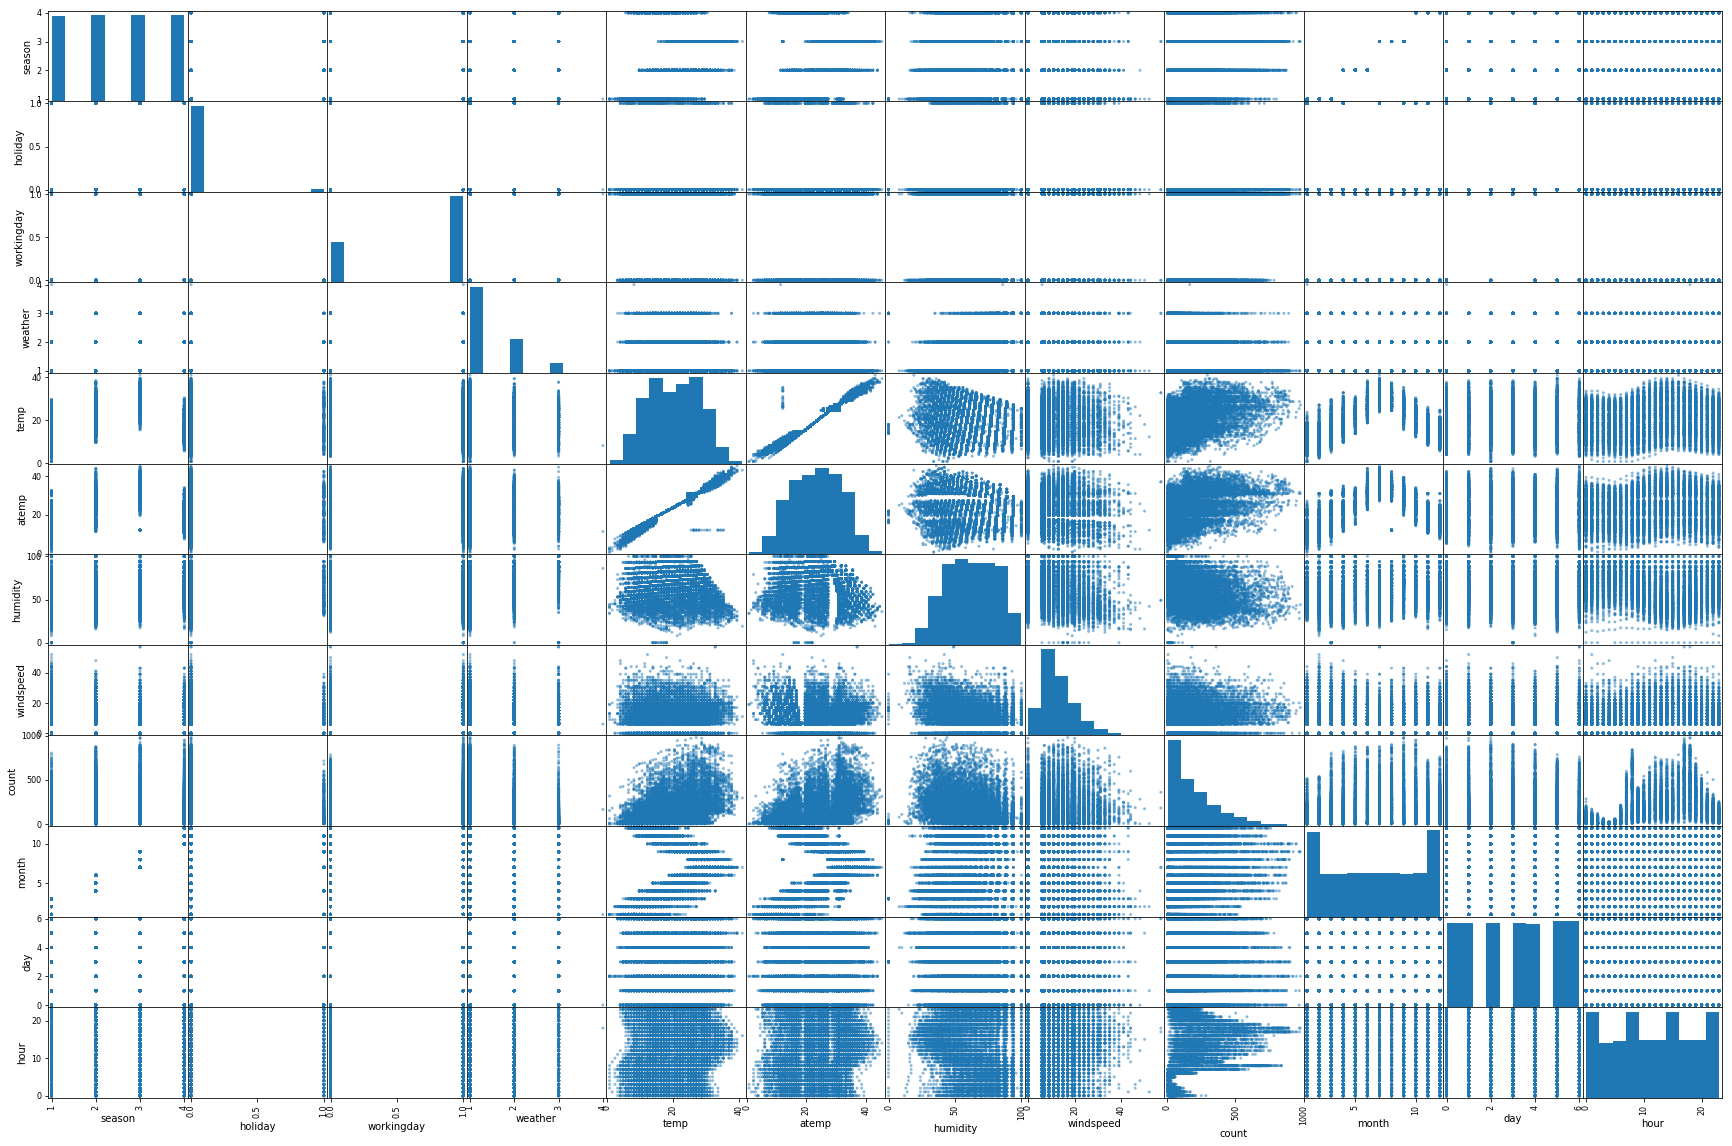

In [9]:
scatter_matrix(bikes_df, figsize=(30,20));

Hour might have more complex effect on count. So we will use the quadratic term regarding it.

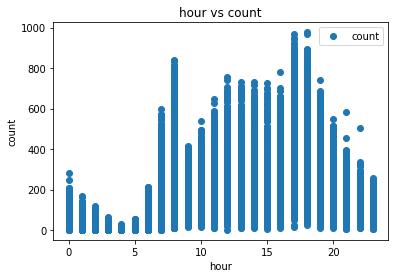

In [32]:
bikes_df.plot(x='hour', y='count', style='o')
plt.title('hour vs count')
plt.xlabel('hour')
plt.ylabel('count')
plt.show()

### Applying ML algorithms

Let's apply several ML algorithms to our data and measure their performance by using cross validation score. 

For cross validation let's use Time Series Split which is a variation of k-fold. It returns first k folds as train set and the (k+1)th fold as test set. Unlike standard cross-validation methods, successive training sets are supersets of those that come before them. 
The experiments we make have been also performed using Shuffle Split (which gives better results). However, probably Time Series Split is the better choice for the time series data we are working with.

#### Linear regression model

In [113]:
def prepare(ds):
    
    categoricalFeatureNames = ["season", "holiday", "workingday", "weather", "weekday", "month", "year", "hour"]
    numericalFeatureNames = ["temp", "humidity", "windspeed", "atemp"]
    
    X_cols = ds[numericalFeatureNames].copy()
    for var in categoricalFeatureNames:
        X_cols[var] = ds[var].astype("category")
        
    X_cols['sqr_hour'] = ds[['hour']] ** 2
    
    X = X_cols.values.reshape(len(X_cols), -1)
    
    return PolynomialFeatures(1).fit_transform(X)


In [114]:
# cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
cv = TimeSeriesSplit(max_train_size=None, n_splits=3)

print("LINEAR REGRESSION")

linear_scores = []
linear_scores_std = []
for month_index in range(1, 25):
    monthly_df = bikes_df[bikes_df.month_index <= month_index]
    
    X = prepare(monthly_df)
    y = monthly_df['count'].values.reshape(-1, 1)

    clf = LinearRegression().fit(X, y)

    scores = cross_val_score(clf, X, y, cv=cv)
    linear_scores.append(scores.mean())
    linear_scores_std.append(scores.std())

print("Accuracy of Linear Regressor at last month: {0:.2f} (+/- {1:.2f})".format(linear_scores[-1], linear_scores_std[-1]))


LINEAR REGRESSION
Accuracy of Linear Regressor at last month: 0.32 (+/- 0.05)


#### Random Forest

In [12]:
# cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
cv = TimeSeriesSplit(max_train_size=None, n_splits=3)

print("RANDOM FOREST REGRESSOR")

random_forest_scores = []
random_forest_scores_std = []
for month_index in range(1, 25):
    monthly_df = bikes_df[bikes_df.month_index <= month_index]
    
    X = monthly_df.drop(['count', 'month_index', 'year'], axis = 1).values
    y = monthly_df['count'].values
    
    svc = RandomForestRegressor(n_estimators = 100).fit(X, y)
        
    scores = cross_val_score(svc, X, y, cv=cv)
    random_forest_scores.append(scores.mean())
    random_forest_scores_std.append(scores.std())
#     print("{0} \t{1:.2f} (+/- {2:.2f})".format(month_index, scores.mean(), scores.std()))
    
print("Accuracy of Random Forest Regressor at last month: {0:.2f} (+/- {1:.2f})".format(random_forest_scores[-1], random_forest_scores_std[-1]))


RANDOM FOREST REGRESSOR
Accuracy of Random Forest Regressor at last month: 0.70 (+/- 0.12)


#### Support Vector Regression

In [13]:
# cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
cv = TimeSeriesSplit(max_train_size=None, n_splits=3)

print("SUPPORT VECTOR REGRESSION")

svr_scores = []
svr_scores_std = []
for month_index in range(1, 25):
    monthly_df = bikes_df[bikes_df.month_index <= month_index]
    
    X = monthly_df.drop(['count', 'month_index', 'year'], axis = 1).values
    y = monthly_df['count'].values
    
    svc = SVR(kernel ='rbf', C = 10, gamma = .001).fit(X, y)
        
    scores = cross_val_score(svc, X, y, cv=cv)
    svr_scores.append(scores.mean())
    svr_scores_std.append(scores.std())
#     print("{0} \t{1:.2f} (+/- {2:.2f})".format(month_index, scores.mean(), scores.std()))
    
print("Accuracy of Support Vector Regressor at last month: {0:.2f} (+/- {1:.2f})".format(svr_scores[-1], svr_scores_std[-1]))


SUPPORT VECTOR REGRESSION
Accuracy of Support Vector Regressor at last month: 0.18 (+/- 0.08)


### Comparing the models

Let's plot cross-validation scores of all three models during the 24 months of the training. 

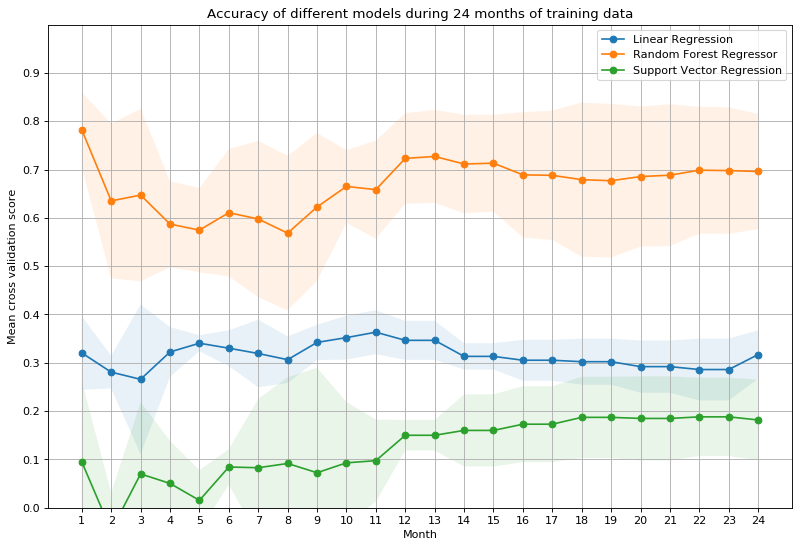

In [117]:
def plot_with_accuracy(x, y, accuracy, label):
    plt.plot(x, y, 'o-',
             label=label)
    plt.fill_between(x, [a_i - b_i for a_i, b_i in zip(y, accuracy)],
                     [a_i + b_i for a_i, b_i in zip(y, accuracy)], alpha=0.1)

def plotCrossValidationScores(title):
    plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

    plt.title(title)
    plt.xlabel("Month")
    plt.ylabel("Mean cross validation score")
    plt.ylim(0,1)
    
    plt.grid()
    
    x_vals = range(1, 25)
    
    plt.xticks(x_vals)
    plt.yticks(np.arange(0, 1, step=0.1))
    
    plot_with_accuracy(x_vals, linear_scores, linear_scores_std, "Linear Regression")
    plot_with_accuracy(x_vals, random_forest_scores, random_forest_scores_std, "Random Forest Regressor")
    plot_with_accuracy(x_vals, svr_scores, svr_scores_std, "Support Vector Regression")
    
    plt.legend(loc="best")

    
plotCrossValidationScores("Accuracy of different models during 24 months of training data")

We can see that __Random Forest Regressor__ gives best result among these three models.

Another observation we can make looking at the learning curves is that all three models tend to have relatively stable scores after 12 months. This could be because the weather of each _month_ affects the number of bikes rented, and after the first year, the model has already seen the data of each month.

#### Grid Search

Now that we saw that random forest regressor is giving us the best results among the three discussed models, let's use Grid Search to try to optimize the hyperparameters we use. We try to optimize the following parameters: 
* n_estimators, which is the number of trees in the foreset
* max_features, which is the max number of features considered for splitting a node
* max_depth, which is the max number of levels in each decision tree


In [91]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

tuned_parameters = [{
    'n_estimators': [10, 100, 500],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [4, 5, 6, 7, 8]
}]
scores = ['r2']
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
# cv = TimeSeriesSplit(max_train_size=None, n_splits=3)

for score in scores:
    clf = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv=cv, scoring=score)

    clf.fit(X, y)

    print("Best parameters set found on development set:\n")
    print(clf.best_params_)
    print(clf.best_estimator_)
    print("Grid scores on development set:\n")
    
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on development set:

{'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
Grid scores on development set:

0.584 (+/-0.015) for {'max_depth': 4, 'max_features': 'auto', 'n_estimators': 10}
0.586 (+/-0.019) for {'max_depth': 4, 'max_features': 'auto', 'n_estimators': 100}
0.586 (+/-0.021) for {'max_depth': 4, 'max_features': 'auto', 'n_estimators': 500}
0.509 (+/-0.055) for {'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 10}
0.505 (+/-0.019) for {'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 100}
0.505 (+/-0.016) for {'max_depth': 4, 'max_features': 'sqrt', 'n

The best score is achieved by having 500 estimators and the score is increasing with the growth of max_depth. So, we will not set max_depth, which means that the nodes are expanded until all leaves are pure.

Now, let's use the best estimator we found by GridSearch and __plot the learning curves__.

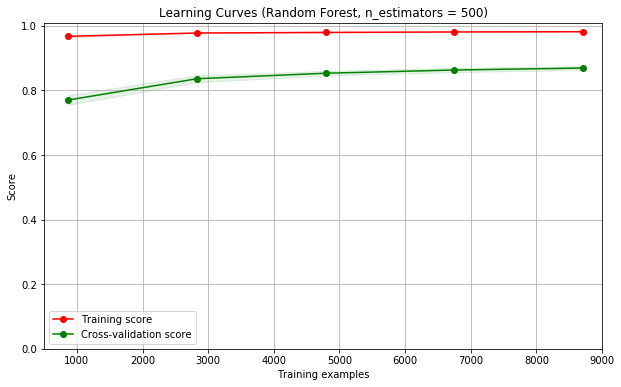

In [125]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlim(500, 9000)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


title = "Learning Curves (Random Forest, n_estimators = 500)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0).split(X)
estimator = RandomForestRegressor(n_estimators = 500)
plot_learning_curve(estimator, title, X, y, (0.0, 1.01), cv=cv, n_jobs=4)
plt.show()

The gap between lines migth indicate that we are dealing with high variance. This might be fixed by increasing the training data or by using less features. 

Now, let's try to calculate Root Mean Squared Logarithmic Error for our estimator and visualize some predicted values. 

train score: 0.992, test score: 0.860
RMSLE 0.4285 

train score: 0.993, test score: 0.570
RMSLE 0.6093 

train score: 0.984, test score: 0.661
RMSLE 0.4554 



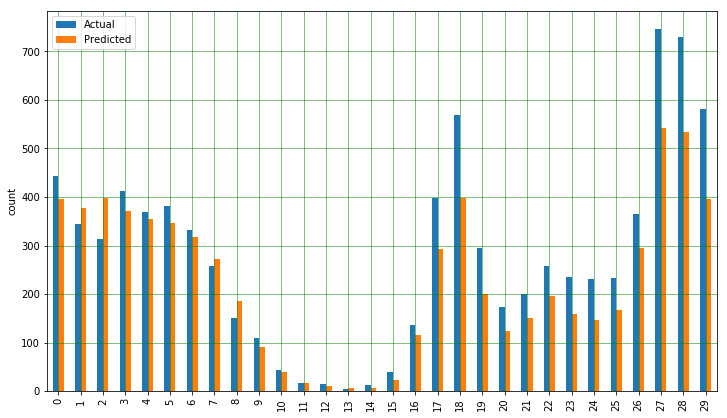

In [120]:
X = bikes_df.drop(['count', 'month_index', 'year'], axis = 1).values
y = bikes_df['count'].values
    
cv = TimeSeriesSplit(max_train_size=None, n_splits=3).split(X)

for train, test in cv:

    svc = RandomForestRegressor(n_estimators = 500).fit(X[train], y[train])
    print("train score: {0:.3f}, test score: {1:.3f}".format(
        svc.score(X[train], y[train]), svc.score(X[test], y[test])))
    
    predictions = svc.predict(X[test])
    rmsle = np.sqrt(mean_squared_log_error(y[test], predictions))
    
    print("RMSLE {0:.4f} \n".format(rmsle))
    
df = pd.DataFrame({'Actual': y[test].flatten(), 'Predicted': predictions.flatten()})

df1 = df.head(30)
df1.plot(kind='bar',figsize=(12, 7))
plt.ylabel('count')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

## Testing 

Previous experiments showed that Random Forest Regressor with 500 trees in the forest performs best on this problem. Let's use it to __predict__ the values in the test dataset. Since we don't have test data target values, we will submit the result to Kaggle competition and measure the performace by the score we receive.

In [42]:
test_df = pd.read_csv("data/test.csv")

test_df['year'] = pd.DatetimeIndex(test_df.datetime).year
test_df['month'] = pd.DatetimeIndex(test_df.datetime).month
test_df['weekday'] = pd.DatetimeIndex(test_df.datetime).dayofweek
test_df['hour'] = pd.DatetimeIndex(test_df.datetime).hour

datetimes = test_df['datetime']
test_df = test_df.drop(['datetime'], axis = 1)
test_df['month_index'] = (test_df['year'] - 2010) * test_df['month']

In [86]:
# Predictions using only prior data
predictions_dict = []

for month_index in range(1, 25):
    monthly_df = bikes_df[bikes_df.month_index <= month_index]
    monthly_df1 = bikes_df[bikes_df.month_index == month_index]

    monthly_test_df = test_df[test_df.month_index == month_index]
    
    X = monthly_df.drop(['count', 'month_index', 'year'], axis = 1).values
    y = monthly_df['count'].values
    
    X_test = monthly_test_df.drop(['month_index', 'year'], axis = 1).values

    if len(X_test) == 0:
        continue

    svc = RandomForestRegressor(n_estimators = 500).fit(X, y)

    predictions = svc.predict(X_test)
    predictions_dict.append(pd.DataFrame(predictions))

res = pd.concat(predictions_dict)

In [85]:
output = pd.DataFrame({ 'datetime' : datetimes, 'count': res.values.ravel() })
output.to_csv('bikes-predictions_with_prior_data.csv', index = False)
output.head()

,count,datetime
0,8.116,2011-01-20 00:00:00
1,12.336,2011-01-20 01:00:00
2,11.856,2011-01-20 02:00:00
3,3.804,2011-01-20 03:00:00
4,2.982,2011-01-20 04:00:00


In [104]:
# Predictions using all the data
X_test = test_df.drop(['month_index'], axis = 1).values

X = bikes_df.drop(['count'], axis = 1).values
y = bikes_df['count'].values

svc = RandomForestRegressor(n_estimators = 500).fit(X, y)
predictions = svc.predict(X_test)

output = pd.DataFrame({ 'datetime' : datetimes, 'count': predictions })
output.to_csv('bikes-predictions.csv', index = False)

Kaggle score of this challenge is the __Root Mean Squared Logarithmic Error__ that measures the ratio between the actual and predicted values. 
We prepared 2 submissions: 
* One, training the model with the __entire train data__ set that we have. Received score: __0.47017__.
* The other, training the model for each month using the __data available prior to it__. Received score: __1.29933__.

Having lower score in the second case is expected since we have smaller training data set for each month.

<img src="/project/kaggle_res.png"> </img>

The first score of 0.47017 can be compared with our own RMSLE on the train data with TrainTestSplit cross validation, which was 0.45505. This values are close to each other and thus, the model seems to be performing well. 

#### Possible improvements
* Improve the dataset features, as described in _Data Visualizations_ section:
    * Remove outliers
    * Bring count close to Normal distribution by taking log transformation on it
    * Fill 0's in windspeed by predictions
* Use fewer features
* Use a larger training dataset 

### Conclusion

In this project, we analyzed Bike sharing demand dataset, performed feature engineering and applied several ML algorithms to it. Using Cross Validation and Grid Search we found the best performing model among them, which was Random Forest Resgressor. We used the model to predict the demand on the test dataset and received a result which is not the best, however, seems to be a good starting point. 

